In [10]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim


In [11]:
# specify path to the dataset
train_DATASET_PATH = "train"
test_DATASET_PATH = "test"
# specify the paths to our training and validation set 
TRAINING = "training"
VAL = "val"
# set the input height and width
INPUT_HEIGHT = 64
INPUT_WIDTH = 64
# set the batch size and validation data split
BATCH_SIZE = 8
VAL_SPLIT = 0.1

In [12]:
# import necessary packages
from imutils import paths
import numpy as np
import shutil
import os

In [13]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	if os.path.exists(folder):
		return
	if not os.path.exists(folder):
		os.makedirs(folder)
	# loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)
		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)
		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		# check if the image already exists at the destination path
		if not os.path.exists(destination):# copy the current image to the destination path only if it doesn't exist
			shutil.copy(path, destination)

In [14]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(train_DATASET_PATH))
np.random.shuffle(imagePaths)
# generate training and validation paths
valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, TRAINING)
copy_images(valPaths, VAL)

[INFO] loading image paths...
[INFO] copying training and validation images...


In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [16]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE, BATCH_SIZE))
	# loop over the batch size
	for i in range(0, BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()

In [17]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

In [18]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize, hFlip, vFlip, rotate,
        transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [19]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root=TRAINING,
        transform=trainTransforms)
valDataset = ImageFolder(root=VAL, 
        transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(
        len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(
        len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 9117 samples...
[INFO] validation dataset contains 1013 samples...


In [20]:
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, 
        batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)

[INFO] creating training and validation set dataloaders...


[INFO] visualizing training and validation batch...


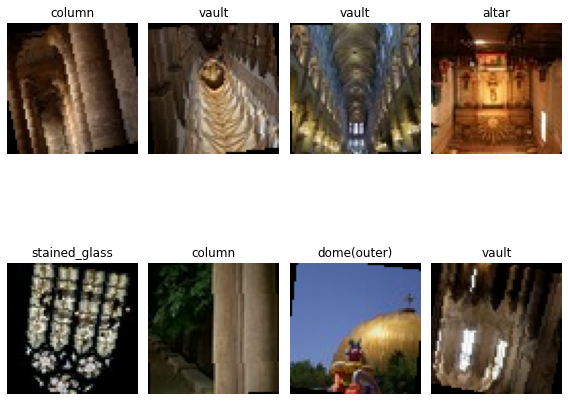

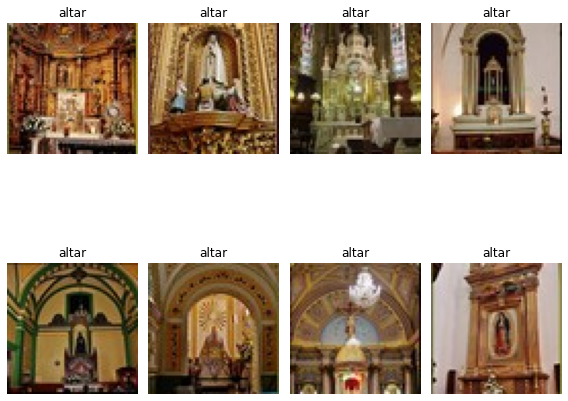

In [21]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))
# visualize the training and validation set batches
print("[INFO] visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

In [22]:
trainDataset

Dataset ImageFolder
    Number of datapoints: 9117
    Root location: training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.25)
               RandomVerticalFlip(p=0.25)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [23]:
len(trainDataLoader)

1140

In [24]:
from collections import Counter

class_counts = dict(Counter(trainDataset.targets))

for class_label, count in class_counts.items():
    print(f'Class {trainDataset.classes[class_label]}: {count} samples')

class_counts = dict(Counter(valDataset.targets))

for class_label, count in class_counts.items():
    print(f'(val) Class {valDataset.classes[class_label]}: {count} samples')


Class altar: 747 samples
Class apse: 451 samples
Class bell_tower: 951 samples
Class column: 1698 samples
Class dome(inner): 530 samples
Class dome(outer): 1055 samples
Class flying_buttress: 376 samples
Class gargoyle: 1422 samples
Class stained_glass: 897 samples
Class vault: 990 samples
(val) Class altar: 81 samples
(val) Class apse: 54 samples
(val) Class bell_tower: 106 samples
(val) Class column: 216 samples
(val) Class dome(inner): 59 samples
(val) Class dome(outer): 120 samples
(val) Class flying_buttress: 29 samples
(val) Class gargoyle: 140 samples
(val) Class stained_glass: 101 samples
(val) Class vault: 107 samples


In [25]:
# Initialize a dictionary to keep track of class occurrences in batches
class_occurrences = {}
batch_count = 0
# Iterate through the DataLoader
for images, labels in trainDataLoader:
    batch_count += 1
    # Update class occurrences in batches
    for label in labels:
            if label.item() in class_occurrences:
                class_occurrences[label.item()] += 1
            else:       
                class_occurrences[label.item()] = 1
# Print class occurrences in batches
total_batches = len(trainDataLoader)
for class_label, count in class_occurrences.items():
    print(f'Class {class_label}: {count / total_batches:.2f}% samples per batch (on average)')


Class 3: 1.49% samples per batch (on average)
Class 6: 0.33% samples per batch (on average)
Class 8: 0.79% samples per batch (on average)
Class 7: 1.25% samples per batch (on average)
Class 9: 0.87% samples per batch (on average)
Class 2: 0.83% samples per batch (on average)
Class 5: 0.93% samples per batch (on average)
Class 4: 0.46% samples per batch (on average)
Class 0: 0.66% samples per batch (on average)
Class 1: 0.40% samples per batch (on average)


In [26]:
from torch.utils.data.sampler import WeightedRandomSampler


num_samples = len(trainDataset)
# Define the weights for each class based on their inverse frequency in the dataset
class_counts = dict(Counter(trainDataset.targets))
total_count = sum(class_counts.values())
class_weights = {k: count / total_count for k, count in class_counts.items()}
class_weights = list(class_weights.values())
labels = trainDataset.targets
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=False)

# Create the DataLoader using the sampler
dataloader = DataLoader(trainDataset, batch_size=32, sampler=sampler)

In [27]:
# Initialize a dictionary to keep track of class occurrences in batches
class_occurrences = {}
batch_count = 0
# Iterate through the DataLoader
for images, labels in dataloader:
    batch_count += 1
    # Update class occurrences in batches
    for label in labels:
            if label.item() in class_occurrences:
                class_occurrences[label.item()] += 1
            else:       
                class_occurrences[label.item()] = 1
# Print class occurrences in batches
total_batches = len(dataloader)
for class_label, count in class_occurrences.items():
    print(f'Class {class_label}: {count / total_batches:.2f}% samples per batch (on average)')


Class 4: 1.86% samples per batch (on average)
Class 5: 3.70% samples per batch (on average)
Class 3: 5.96% samples per batch (on average)
Class 2: 3.34% samples per batch (on average)
Class 8: 3.15% samples per batch (on average)
Class 9: 3.47% samples per batch (on average)
Class 6: 1.32% samples per batch (on average)
Class 0: 2.62% samples per batch (on average)
Class 7: 4.99% samples per batch (on average)
Class 1: 1.58% samples per batch (on average)


In [28]:
def train(net, dataloader, criterion, optimizer):
  # loop over the dataset multiple times
    net.train()

    running_loss = 0.0
    train_acc = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item() / len(outputs)

    train_loss = running_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [29]:
def test(net, dataloader, criterion):
    net.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            #X, y = X.to(device), y.to(device)
            test_pred_logits = net(X)

            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [30]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple

def plot_loss_curves(results, title):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=15)

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def calculate_performance(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        class_names: List[str],
        title: str) -> Tuple[float, float, float]:
    model.eval()

    y_pred = []
    y_true = []
    test_acc = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            #X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            output = (torch.max(torch.exp(test_pred_logits), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_acc = test_acc / len(dataloader)
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    df_cm = pd.DataFrame(cf_matrix, index=[i for i in class_names],
                         columns=[i for i in class_names])
    plt.figure(figsize=(12, 7))
    plt.title(title)
    sns.heatmap(df_cm, annot=True)
    plt.show()

    return test_acc, f1, precision, recall

In [57]:
class Net(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.cn1 = nn.Conv2d(input_shape, 32, 3)
        self.cn2 = nn.Conv2d(32, 64, 3)
        self.cn3 = nn.Conv2d(64, 128, 3)
        #self.cn4 = nn.Conv2d(128, 256, 3)
        #self.cn5 = nn.Conv2d(256, 256, 3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.max_pool2 = nn.MaxPool2d(2)
        self.upsampling1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.upsampling2 = nn.Upsample(scale_factor=2, mode="nearest")

        self.dcn1 = nn.ConvTranspose2d(32, input_shape, 3)
        self.dcn2 = nn.ConvTranspose2d(64, 32, 3)
        self.dcn3 = nn.ConvTranspose2d(128, 64, 3)
        #self.dcn4 = nn.ConvTranspose2d(256, 128, 3)
        #self.dcn5 = nn.ConvTranspose2d(256, 256, 3)
        
        self.classifier = nn.Linear(in_features=128*12*12, out_features=output_shape, bias=False)
        self.axs = [128,12,12]
        
    def feature_extr(self, x):
        h = self.max_pool1(self.cn1(x))
        h = self.max_pool2(self.cn2(h))
        h = (self.cn3(h))
        #h = self.cn4(h)
        #h = self.max_pool2(self.cn5(h))
        return h

    def forward(self, x):
        h = self.feature_extr(x)
        #print(h.shape)
        h = h.view(h.shape[0], -1)
        h = self.classifier(h)
        return h
    
    def decode(self, x):
        self.dcn1.weight = nn.Parameter(self.cn1.weight)
        self.dcn2.weight = nn.Parameter(self.cn2.weight)
        self.dcn3.weight = nn.Parameter(self.cn3.weight)
        #self.dcn4.weight = nn.Parameter(self.cn4.weight)
        #self.dcn5.weight = nn.Parameter(self.cn5.weight)
        # print(self.dcn3.weight.data.shape, self.cn3.weight.data.transpose(0, 1).shape)
        #h = self.upsampling2(self.dcn5(x))
        #h = (self.dcn4(x))
        h = self.upsampling2(self.dcn3(x))
        h = self.upsampling1(self.dcn2(h))
        h = self.dcn1(h)
        return h
    
    @torch.no_grad()
    def im_gen(self, x):
        h = torch.matmul(x, self.classifier.weight.data)
        h = h.view([h.shape[0]]+self.axs)
        img = self.decode(h)
        return img

Epoch: 1 | train_loss: 2.1567 | train_acc: 0.2088 | test_loss: 2.1799 | test_acc: 0.2561
Epoch: 2 | train_loss: 2.0463 | train_acc: 0.2754 | test_loss: 2.0494 | test_acc: 0.3077
Epoch: 3 | train_loss: 1.9094 | train_acc: 0.3365 | test_loss: 1.9362 | test_acc: 0.3258
Epoch: 4 | train_loss: 1.8185 | train_acc: 0.3539 | test_loss: 1.8759 | test_acc: 0.3496
Epoch: 5 | train_loss: 1.7632 | train_acc: 0.3712 | test_loss: 1.8281 | test_acc: 0.3766
Epoch: 6 | train_loss: 1.7213 | train_acc: 0.3882 | test_loss: 1.7970 | test_acc: 0.3890
Epoch: 7 | train_loss: 1.6826 | train_acc: 0.4056 | test_loss: 1.7750 | test_acc: 0.3909
Epoch: 8 | train_loss: 1.6444 | train_acc: 0.4093 | test_loss: 1.7492 | test_acc: 0.3969
Epoch: 9 | train_loss: 1.6181 | train_acc: 0.4187 | test_loss: 1.7323 | test_acc: 0.3909
Epoch: 10 | train_loss: 1.5876 | train_acc: 0.4296 | test_loss: 1.7333 | test_acc: 0.3909
Epoch: 11 | train_loss: 1.5761 | train_acc: 0.4353 | test_loss: 1.7286 | test_acc: 0.4057
Epoch: 12 | train_l

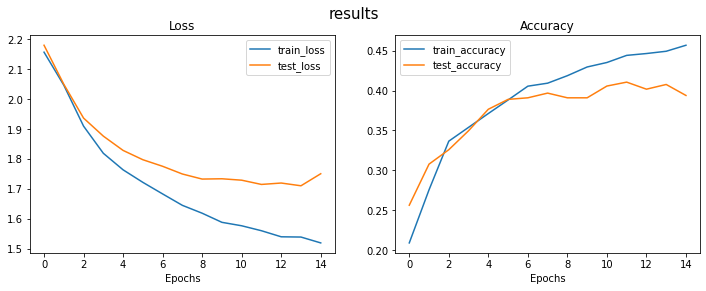

In [58]:
results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

net = Net(3, len(trainDataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

epochz = 15
for epoch in range(epochz):
    train_loss, train_acc = train(net, dataloader, criterion, optimizer)
    test_loss, test_acc= test(net, valDataLoader, criterion)

    print(
        f"Epoch: {epoch + 1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

plot_loss_curves(results, title="results")

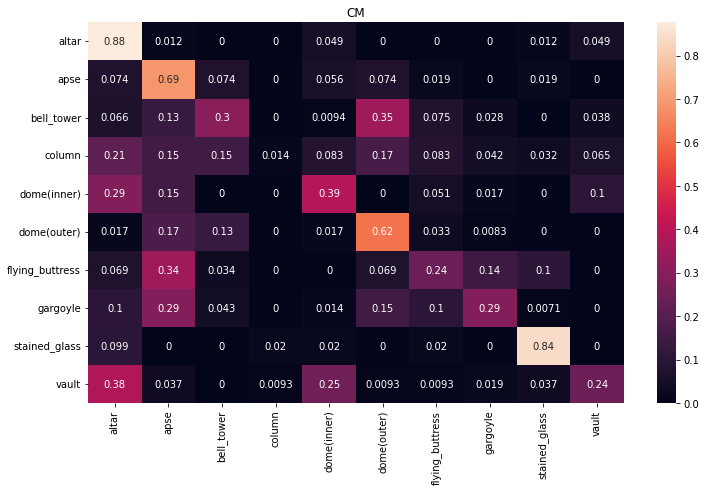

Accuracy = 0.3938976377952756, f1 score = 0.37208487778800786, precision = 0.42120516766698646, recall = 0.45028125173681105


In [59]:
acc, f1, precision, recall = calculate_performance(net, 
                                                  valDataLoader,  
                                                  list(valDataset.classes), 
                                                  "CM")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")

<Axes: >

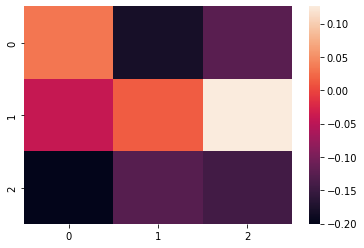

In [60]:
k1 = net.cn1.weight[1,1,].data.numpy()
sns.heatmap(k1)

<Axes: >

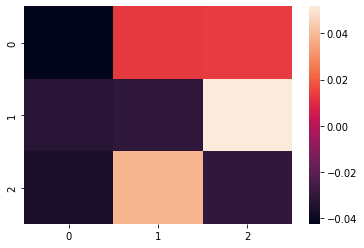

In [61]:
k2 = net.cn2.weight[1,1,].data.numpy()
sns.heatmap(k2)

<Axes: >

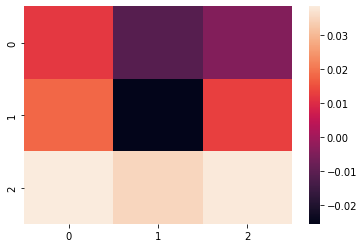

In [62]:
k3 = net.cn3.weight[1,1,].data.numpy()
sns.heatmap(k3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


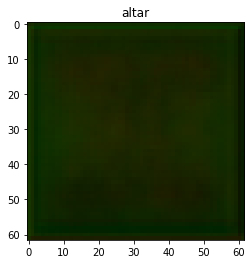

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


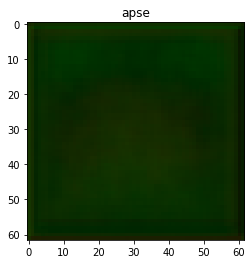

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


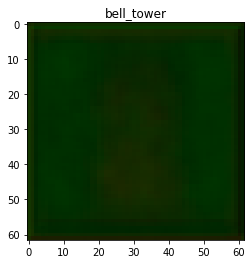

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


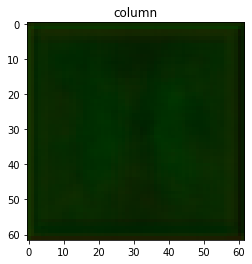

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


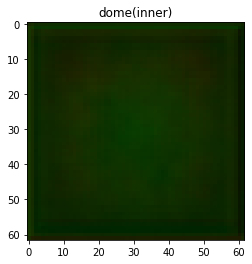

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


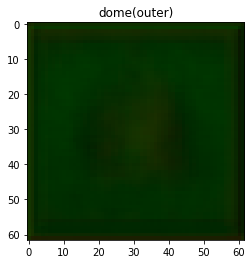

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


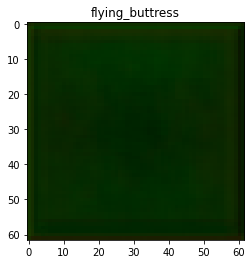

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


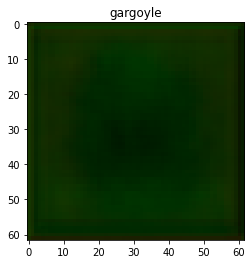

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


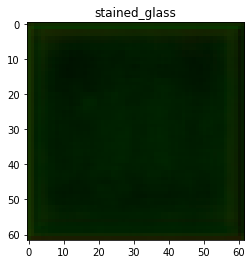

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


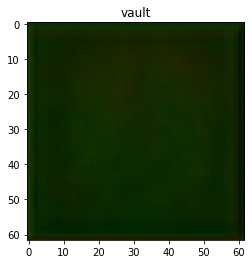

In [89]:
classes = len(trainDataset.classes)
for c in range(classes):
    y = torch.zeros(1, 10)
    y[0][c] = 1
    img = net.im_gen(y).squeeze(0).permute(1,2,0).numpy()
    label = trainDataset.classes[c]
    plt.imshow(img)
    plt.title(label)
    plt.show()